In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Set default sizes for figures.
plt.style.use("default") # style matplotlib
plt.rc("axes", labelsize = 12) # fontsize of the x and y labels
plt.rc("axes", titlesize = 15) # fontsize of the axes title
plt.rc("xtick", labelsize = 12) # fontsize of the tick labels
plt.rc("ytick", labelsize = 12) # fontsize of the tick labels
plt.rc("legend", fontsize = 12) # legend fontsize

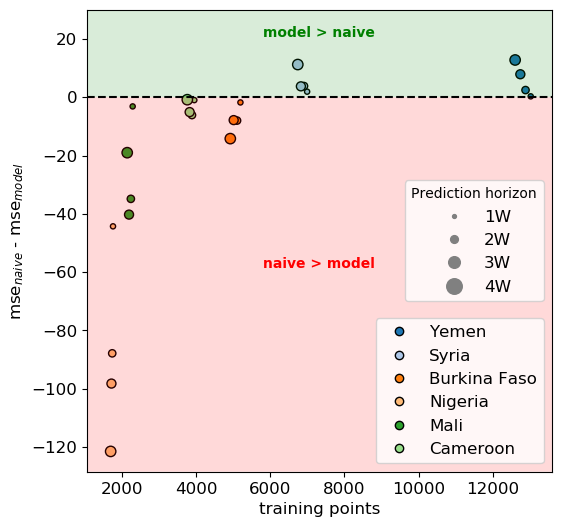

In [3]:
fig, axs = plt.subplots(figsize = (6, 6))

# Load corresponding best files for each country.
countries = [("Yemen", 1), ("Syria", 3), ("Burkina Faso", 2), ("Nigeria", 1), ("Mali", 2), ("Cameroon", 2),] #("Niger", 1)] #, 

for i,country in enumerate(countries):
    # Load training shapes.
    training_shape = pd.read_csv(f"./{country[0]}/output_hyperparameter_tuning_{country[1]}/training_shapes.csv", header = [0,1], index_col = 0)
    training_shape = training_shape.xs("training points", axis = 1, level = 1, drop_level = False)
    # Load mse loss based on prediction horizons.
    loss_h = pd.read_csv(f"./{country[0]}/output_hyperparameter_tuning_{country[1]}/loss_h.csv", index_col = [0, 1], header = [0, 1]).droplevel(0, axis = 0)
    
    # Concatenate loss and training shape information.
    results = loss_h.stack(["Split"])

    results["diff"] =  results["mse_naive"]-results["mse_model"]
    results = results.unstack().reorder_levels(["Split", "Type"], axis = 1).xs("diff", axis = 1, level = 1, drop_level = False)
    results = pd.concat([results, training_shape], axis = 1).sort_index(axis = 1)
    
    # Take the mean across all the splits.
    results_mean = results.groupby(axis = 1, level = 1).mean()
    # Select some prediction horizon.
    results_mean = results_mean.loc[[7,14,21,28]]

    results_mean.plot.scatter(x = "training points", y = "diff", s = results_mean.index.values*2, marker = "o", 
                              color = plt.get_cmap("tab20")(i), ax = axs, legend = False, linewidths = 1, 
                              edgecolors = "black")

# Add 0 line.
axs.axhline(y = 0, color = "black", linestyle = "--")
    
# Legend.
h = [plt.plot([],[], color = plt.get_cmap("tab20")(i), marker = "o", ls = "", markeredgewidth = 1, 
              markeredgecolor = "black")[0] for i,country in enumerate(countries)]
h = plt.legend(handles = h, labels = [country[0] for country in countries], loc = "best")

h1 = [plt.plot([],[], color = "gray", marker = "o", ms = i, ls = "")[0] for i in results_mean.index.values/2.5]
axs.legend(handles = h1, labels = ["1W", "2W", "3W", "4W"],loc = "center right", title="Prediction horizon")

plt.gca().add_artist(h)

axs.set_xlabel("training points")
axs.set_ylabel("mse$_{naive}$ - mse$_{model}$")

a=(axs.get_xlim()[0],axs.get_xlim()[1])
b=(axs.get_ylim()[0],50)#axs.get_ylim()[1])

axs.fill_between(np.arange(a[0], a[1]), 0, b[1], facecolor='green', alpha=0.15)
axs.fill_between(np.arange(a[0], a[1]), 0, b[0], facecolor='red', alpha=0.15)

axs.set_xlim(a)
axs.set_ylim((b[0], 30))

axs.text(0.5, 0.45, "naive > model", color="red", horizontalalignment='center',verticalalignment='center', 
         transform=axs.transAxes, weight='bold', fontsize=10)
axs.text(0.5, .95, "model > naive", color="green", horizontalalignment='center',verticalalignment='center', 
         transform=axs.transAxes, weight='bold', fontsize=10)

fig.savefig("image_1.png" , bbox_inches = "tight", dpi = 300)

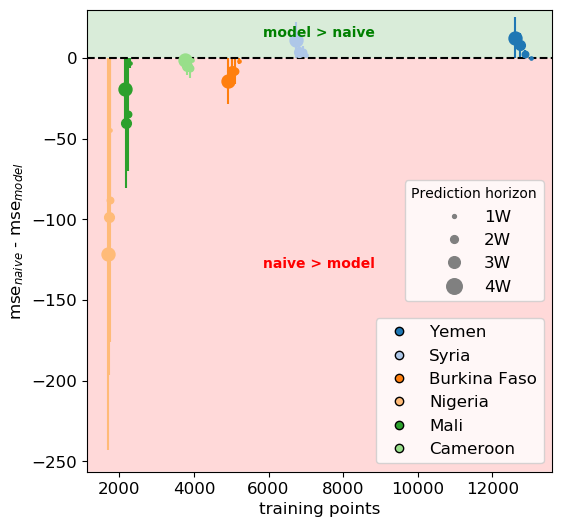

In [4]:
fig, axs = plt.subplots(figsize = (6, 6))

# Load corresponding best files for each country.
countries = [("Yemen", 1), ("Syria", 3), ("Burkina Faso", 2), ("Nigeria", 1), ("Mali", 2), ("Cameroon", 2),] #("Niger", 1)] #, 

for i,country in enumerate(countries):
    # Load training shapes.
    training_shape = pd.read_csv(f"./{country[0]}/output_hyperparameter_tuning_{country[1]}/training_shapes.csv", header = [0,1], index_col = 0)
    training_shape = training_shape.xs("training points", axis = 1, level = 1, drop_level = False)
    # Load mse loss based on prediction horizons.
    loss_h = pd.read_csv(f"./{country[0]}/output_hyperparameter_tuning_{country[1]}/loss_h.csv", index_col = [0, 1], header = [0, 1]).droplevel(0, axis = 0)
    
    # Concatenate loss and training shape information.
    results = loss_h.stack(["Split"])
    # For each split get difference between 'mse_naive' and 'mse_model'.
    results["diff"] =  results["mse_naive"]-results["mse_model"]
    results = results.unstack().reorder_levels(["Split", "Type"], axis = 1).xs("diff", axis = 1, level = 1, drop_level = False)
    results = pd.concat([results, training_shape], axis = 1).sort_index(axis = 1)
    
    # Take the mean across all the splits.
    results_mean = results.groupby(axis = 1, level = 1).mean()
    results_std = results.groupby(axis = 1, level = 1).std()
    # Select some prediction horizon.
    results_mean = results_mean.loc[[7,14,21,28]]
    results_std = results_std.loc[[7,14,21,28]]

    for j in range(len(results_mean)):
        axs.errorbar(results_mean.iloc[j]["training points"], results_mean.iloc[j]["diff"],
                     yerr = results_mean.iloc[j]["diff"], marker = "o", linestyle = "none", 
                     color = plt.get_cmap("tab20")(i), markersize = results_mean.index[j]/3)
        #axs.errorbar(results_mean.iloc[j]["training points"], results_mean.iloc[j]["diff"],
        #             yerr = results_mean.iloc[j]["diff"], marker = "o", linestyle = "none", 
        #             color = "k", markersize = results_mean.index[j]/3+3, zorder = 5)

# Add 0 line.
axs.axhline(y = 0, color = "black", linestyle = "--")
 
# Legend.
h = [plt.plot([],[], color = plt.get_cmap("tab20")(i), marker = "o", ls = "", markeredgewidth = 1, 
              markeredgecolor = "black")[0] for i,country in enumerate(countries)]
h = plt.legend(handles = h, labels = [country[0] for country in countries], loc = "lower right")

h1 = [plt.plot([],[], color = "gray", marker = "o", ms = i, ls = "")[0] for i in results_mean.index.values/2.5]
axs.legend(handles = h1, labels = ["1W", "2W", "3W", "4W"],loc = "center right", title="Prediction horizon")

plt.gca().add_artist(h)

axs.set_xlabel("training points")
axs.set_ylabel("mse$_{naive}$ - mse$_{model}$")

a=(axs.get_xlim()[0],axs.get_xlim()[1])
b=(axs.get_ylim()[0],50)#axs.get_ylim()[1])

axs.fill_between(np.arange(a[0], a[1]), 0, b[1], facecolor='green', alpha=0.15)
axs.fill_between(np.arange(a[0], a[1]), 0, b[0], facecolor='red', alpha=0.15)

axs.set_xlim(a)
axs.set_ylim((b[0], 30))

axs.text(0.5, 0.45, "naive > model", color="red", horizontalalignment='center',verticalalignment='center', 
         transform=axs.transAxes, weight='bold', fontsize=10)
axs.text(0.5, .95, "model > naive", color="green", horizontalalignment='center',verticalalignment='center', 
         transform=axs.transAxes, weight='bold', fontsize=10)

fig.savefig("image_2.png" , bbox_inches = "tight", dpi = 300)

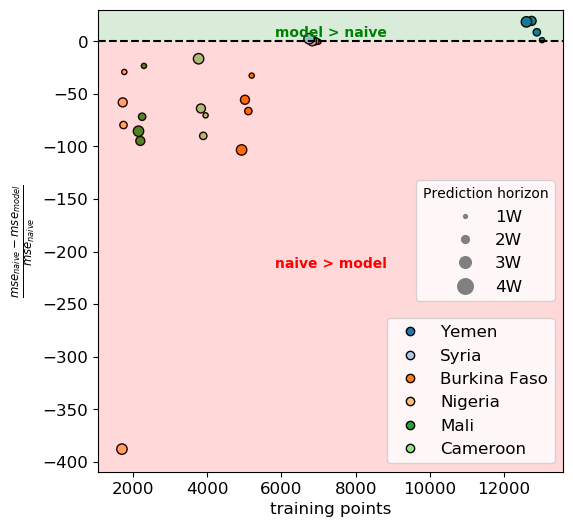

In [5]:
fig, axs = plt.subplots(figsize = (6, 6))

# Load corresponding best files for each country.
countries = [("Yemen", 1), ("Syria", 3), ("Burkina Faso", 2), ("Nigeria", 1), ("Mali", 2), ("Cameroon", 2),] #("Niger", 1)] #, 

for i,country in enumerate(countries):
    # Load training shapes.
    training_shape = pd.read_csv(f"./{country[0]}/output_hyperparameter_tuning_{country[1]}/training_shapes.csv", header = [0,1], index_col = 0)
    training_shape = training_shape.xs("training points", axis = 1, level = 1, drop_level = False)
    # Load mse loss based on prediction horizons.
    loss_h = pd.read_csv(f"./{country[0]}/output_hyperparameter_tuning_{country[1]}/loss_h.csv", index_col = [0, 1], header = [0, 1]).droplevel(0, axis = 0)
    
    # Concatenate loss and training shape information.
    results = loss_h.stack(["Split"])

    results["diff"] =  ((results["mse_naive"]-results["mse_model"])/results["mse_naive"])*100
    results = results.unstack().reorder_levels(["Split", "Type"], axis = 1).xs("diff", axis = 1, level = 1, drop_level = False)
    results = pd.concat([results, training_shape], axis = 1).sort_index(axis = 1)
    
    # Take the mean across all the splits.
    results_mean = results.groupby(axis = 1, level = 1).mean()
    # Select some prediction horizon.
    results_mean = results_mean.loc[[7,14,21,28]]

    results_mean.plot.scatter(x = "training points", y = "diff", s = results_mean.index.values*2, marker = "o", 
                              color = plt.get_cmap("tab20")(i), ax = axs, legend = False, linewidths = 1, 
                              edgecolors = "black")

# Add 0 line.
axs.axhline(y = 0, color = "black", linestyle = "--")
    
# Legend.
h = [plt.plot([],[], color = plt.get_cmap("tab20")(i), marker = "o", ls = "", markeredgewidth = 1, 
              markeredgecolor = "black")[0] for i,country in enumerate(countries)]
h = plt.legend(handles = h, labels = [country[0] for country in countries], loc = "best")

h1 = [plt.plot([],[], color = "gray", marker = "o", ms = i, ls = "")[0] for i in results_mean.index.values/2.5]
axs.legend(handles = h1, labels = ["1W", "2W", "3W", "4W"],loc = "center right", title="Prediction horizon")

plt.gca().add_artist(h)

axs.set_xlabel("training points")
axs.set_ylabel(r"$\frac{mse_{naive} - mse_{model}}{mse_{naive}}$")

a=(axs.get_xlim()[0],axs.get_xlim()[1])
b=(axs.get_ylim()[0],50)#axs.get_ylim()[1])

axs.fill_between(np.arange(a[0], a[1]), 0, b[1], facecolor='green', alpha=0.15)
axs.fill_between(np.arange(a[0], a[1]), 0, b[0], facecolor='red', alpha=0.15)

axs.set_xlim(a)
axs.set_ylim((b[0], 30))

axs.text(0.5, 0.45, "naive > model", color="red", horizontalalignment='center',verticalalignment='center', 
         transform=axs.transAxes, weight='bold', fontsize=10)
axs.text(0.5, .95, "model > naive", color="green", horizontalalignment='center',verticalalignment='center', 
         transform=axs.transAxes, weight='bold', fontsize=10)

fig.savefig("image_3.png" , bbox_inches = "tight", dpi = 300)

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


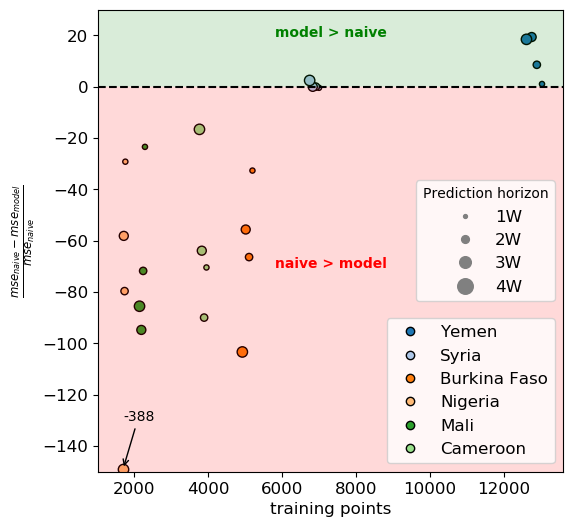

In [6]:
fig, axs = plt.subplots(figsize = (6, 6))

# Load corresponding best files for each country.
countries = [("Yemen", 1), ("Syria", 3), ("Burkina Faso", 2), ("Nigeria", 1), ("Mali", 2), ("Cameroon", 2),] #("Niger", 1)] #, 

for i,country in enumerate(countries):
    # Load training shapes.
    training_shape = pd.read_csv(f"./{country[0]}/output_hyperparameter_tuning_{country[1]}/training_shapes.csv", header = [0,1], index_col = 0)
    training_shape = training_shape.xs("training points", axis = 1, level = 1, drop_level = False)
    # Load mse loss based on prediction horizons.
    loss_h = pd.read_csv(f"./{country[0]}/output_hyperparameter_tuning_{country[1]}/loss_h.csv", index_col = [0, 1], header = [0, 1]).droplevel(0, axis = 0)
    
    # Concatenate loss and training shape information.
    results = loss_h.stack(["Split"])

    results["diff"] =  ((results["mse_naive"]-results["mse_model"])/results["mse_naive"])*100
    results = results.unstack().reorder_levels(["Split", "Type"], axis = 1).xs("diff", axis = 1, level = 1, drop_level = False)
    results = pd.concat([results, training_shape], axis = 1).sort_index(axis = 1)
    
    # Take the mean across all the splits.
    results_mean = results.groupby(axis = 1, level = 1).mean()
    # Select some prediction horizon.
    results_mean = results_mean.loc[[7,14,21,28]]

    results_mean.plot.scatter(x = "training points", y = "diff", s = results_mean.index.values*2, marker = "o", 
                              color = plt.get_cmap("tab20")(i), ax = axs, legend = False, linewidths = 1, 
                              edgecolors = "black")
    
    if len(results_mean[results_mean["diff"] <= -150]) > 0:
        outside = results_mean[results_mean["diff"] <= -150]
        val = round(outside["diff"].values[0])
        val1 = round(outside["training points"].values[0])
        outside["diff"] = -149
        outside.plot.scatter(x = "training points", y = "diff", s = outside.index.values*2, marker = "o", 
                            color = plt.get_cmap("tab20")(i), ax = axs, legend = False, linewidths = 1, 
                            edgecolors = "black")
        axs.annotate(val, xy=(val1, -149), xytext=(val1, -130),
                     arrowprops=dict(arrowstyle="->"))

# Add 0 line.
axs.axhline(y = 0, color = "black", linestyle = "--")
    
# Legend.
h = [plt.plot([],[], color = plt.get_cmap("tab20")(i), marker = "o", ls = "", markeredgewidth = 1, 
              markeredgecolor = "black")[0] for i,country in enumerate(countries)]
h = plt.legend(handles = h, labels = [country[0] for country in countries], loc = "best")

h1 = [plt.plot([],[], color = "gray", marker = "o", ms = i, ls = "")[0] for i in results_mean.index.values/2.5]
axs.legend(handles = h1, labels = ["1W", "2W", "3W", "4W"],loc = "center right", title="Prediction horizon")

plt.gca().add_artist(h)

axs.set_xlabel("training points")
axs.set_ylabel(r"$\frac{mse_{naive} - mse_{model}}{mse_{naive}}$")

a=(axs.get_xlim()[0],axs.get_xlim()[1])
b=(axs.get_ylim()[0],50)#axs.get_ylim()[1])

axs.fill_between(np.arange(a[0], a[1]), 0, b[1], facecolor='green', alpha=0.15)
axs.fill_between(np.arange(a[0], a[1]), 0, b[0], facecolor='red', alpha=0.15)

axs.set_xlim(a)
axs.set_ylim((-150, 30))

axs.text(0.5, 0.45, "naive > model", color="red", horizontalalignment='center',verticalalignment='center', 
         transform=axs.transAxes, weight='bold', fontsize=10)
axs.text(0.5, .95, "model > naive", color="green", horizontalalignment='center',verticalalignment='center', 
         transform=axs.transAxes, weight='bold', fontsize=10)

fig.savefig("image_4.png" , bbox_inches = "tight", dpi = 300)